In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/buiquangmanhhp1999/extract-information-from-identity-card.git
%cd extract-information-from-identity-card/

Cloning into 'extract-information-from-identity-card'...
remote: Enumerating objects: 1316, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 1316 (delta 61), reused 69 (delta 8), pack-reused 1165
Receiving objects: 100% (1316/1316), 113.65 MiB | 29.70 MiB/s, done.
Resolving deltas: 100% (505/505), done.
/content/extract-information-from-identity-card


In [3]:
!pip install gdown
!pip install python-multipart
!gdown https://drive.google.com/uc?id=1pXftFiTGzcXNqsy6jKxQF2WyiOoBmDKU
import shutil
shutil.move(src='transformerocr.pth', dst='src/vietocr/config_text_recognition')

  Created wheel for python-multipart: filename=python_multipart-0.0.5-py3-none-any.whl size=31678 sha256=b7ea1eaf2da79ed78cb5a672f5748f70c626e6a0fe714f4b93a68ce40b6cd545
  Stored in directory: /root/.cache/pip/wheels/2c/41/7c/bfd1c180534ffdcc0972f78c5758f89881602175d48a8bcd2c
Successfully built python-multipart
Downloading...
From: https://drive.google.com/uc?id=1pXftFiTGzcXNqsy6jKxQF2WyiOoBmDKU
To: /content/extract-information-from-identity-card/transformerocr.pth
100% 152M/152M [00:01<00:00, 129MB/s]


'src/vietocr/config_text_recognition/transformerocr.pth'

In [4]:
!pip install -r requirement.txt

     |████████████████████████████████| 516.2 MB 3.3 kB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 51 kB 431 kB/s 
     |████████████████████████████████| 61 kB 206 kB/s 
     |████████████████████████████████| 2.9 MB 41.9 MB/s 
     |████████████████████████████████| 3.0 MB 45.5 MB/s 
     |████████████████████████████████| 454 kB 39.3 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 10.1 MB 51.5 MB/s 
     |████████████████████████████████| 78 kB 5.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: h5py
    Found existing 

<h2> 1. Recognition's result from repo </h2> 

In [5]:
# download another main.py to run easily
!gdown https://drive.google.com/uc?id=1DfTf_NxzshFjZilswOkL69LF0IXlaHrs

Downloading...
From: https://drive.google.com/uc?id=1DfTf_NxzshFjZilswOkL69LF0IXlaHrs
To: /content/extract-information-from-identity-card/main.py
100% 813/813 [00:00<00:00, 373kB/s]


In [15]:
!python main.py -input_file '/content/front.png'

/content/extract-information-from-identity-card/src/merged_model.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  result = self.text_recognition_model.predict_on_batch(np.array(list_ans))
{
  "id": "Z62462375",
  "name": "lê minh anh",
  "birth": "01,01,1ZZ1",
  "home": "p- qT*MF tQTMF tGAMG pGỖ hA gH*MF hA gH*MF",
  "add": "xẢ tG*MG lẶL hTXẾM mẸ lHMG hA nỐH"
}


<h2> 2. Split corners detection and text detection from repo </h2>

<h3> Library </h3>

In [16]:
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
import logging
from google.protobuf import text_format
from google.colab.patches import cv2_imshow
import itertools 


<h3> Config </h3>

In [17]:
corner_detection = {
    'path_to_model': './src/detector/config_corner_detection/model.tflite',
    'path_to_labels': './src/detector/config_corner_detection/label_map.pbtxt',
    'nms_ths': 0.2,
    'score_ths': 0.3
}

text_detection = {
    'path_to_model': './src/detector/config_text_detection/model.tflite',
    'path_to_labels': './src/detector/config_text_detection/label_map.pbtxt',
    'nms_ths': 0.2,
    'score_ths': 0.2

}

text_recognition = {
    'base_config': './src/vietocr/config_text_recognition/base.yml',
    'vgg_config': './src/vietocr/config_text_recognition/vgg-transformer.yml',
    'model_weight': './src/vietocr/config_text_recognition/transformerocr.pth'
}

<h3> Some utils </h3>

In [18]:
def get_center_point(coordinate_dict):
    di = dict()

    for key in coordinate_dict.keys():
        xmin, ymin, xmax, ymax = coordinate_dict[key]
        x_center = (xmin + xmax) / 2
        y_center = (ymin + ymax) / 2
        di[key] = (x_center, y_center)

    return di


def find_miss_corner(coordinate_dict):
    position_name = ['top_left', 'top_right', 'bottom_left', 'bottom_right']
    position_index = np.array([0, 0, 0, 0])

    for name in coordinate_dict.keys():
        if name in position_name:
            position_index[position_name.index(name)] = 1

    index = np.argmin(position_index)

    return index

"""
    Find the missed corner if corners detector only detects 3 corners
"""
def calculate_missed_coord_corner(coordinate_dict):
    thresh = 0

    index = find_miss_corner(coordinate_dict)

    # calculate missed corner coordinate
    # case 1: missed corner is "top_left"
    if index == 0:
        midpoint = np.add(coordinate_dict['top_right'], coordinate_dict['bottom_left']) / 2
        y = 2 * midpoint[1] - coordinate_dict['bottom_right'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['bottom_right'][0] - thresh
        coordinate_dict['top_left'] = (x, y)
    elif index == 1:  # "top_right"
        midpoint = np.add(coordinate_dict['top_left'], coordinate_dict['bottom_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['bottom_left'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['bottom_left'][0] - thresh
        coordinate_dict['top_right'] = (x, y)
    elif index == 2:  # "bottom_left"
        midpoint = np.add(coordinate_dict['top_left'], coordinate_dict['bottom_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['top_right'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['top_right'][0] - thresh
        coordinate_dict['bottom_left'] = (x, y)
    elif index == 3:  # "bottom_right"
        midpoint = np.add(coordinate_dict['bottom_left'], coordinate_dict['top_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['top_left'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['top_left'][0] - thresh
        coordinate_dict['bottom_right'] = (x, y)

    return coordinate_dict


def perspective_transform(image, source_points):
    dest_points = np.float32([[0, 0], [500, 0], [500, 300], [0, 300]])
    M = cv2.getPerspectiveTransform(source_points, dest_points)
    dst = cv2.warpPerspective(image, M, (500, 300))

    return dst


def align_image(image, coordinate_dict):
    if len(coordinate_dict) < 3:
        raise ValueError('Please try again')

    # convert (xmin, ymin, xmax, ymax) to (x_center, y_center)
    coordinate_dict = get_center_point(coordinate_dict)

    if len(coordinate_dict) == 3:
        coordinate_dict = calculate_missed_coord_corner(coordinate_dict)

    top_left_point = coordinate_dict['top_left']
    top_right_point = coordinate_dict['top_right']
    bottom_right_point = coordinate_dict['bottom_right']
    bottom_left_point = coordinate_dict['bottom_left']

    source_points = np.float32([top_left_point, top_right_point, bottom_right_point, bottom_left_point])

    # transform image and crop
    crop = perspective_transform(image, source_points)

    return crop


def non_max_suppression_fast(boxes, labels, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    #
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 1]
    y1 = boxes[:, 0]
    x2 = boxes[:, 3]
    y2 = boxes[:, 2]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    final_labels = [labels[idx] for idx in pick]
    final_boxes = boxes[pick].astype("int")
    return final_boxes, final_labels


def sort_text(detection_boxes, detection_labels):
    detection_labels = np.array(detection_labels)
    id_boxes = detection_boxes[detection_labels == 1]
    name_boxes = detection_boxes[detection_labels == 2]
    birth_boxes = detection_boxes[detection_labels == 3]
    home_boxes = detection_boxes[detection_labels == 4]
    add_boxes = detection_boxes[detection_labels == 5]

    # arrange boxes
    id_boxes = sort_each_category(id_boxes)
    name_boxes = sort_each_category(name_boxes)
    birth_boxes = sort_each_category(birth_boxes)
    home_boxes = sort_each_category(home_boxes)
    add_boxes = sort_each_category(add_boxes)

    return id_boxes, name_boxes, birth_boxes, home_boxes, add_boxes


def get_y1(x):
    return x[0]


def get_x1(x):
    return x[1]


def sort_each_category(category_text_boxes):
    min_y1 = min(category_text_boxes, key=get_y1)[0]

    mask = np.where(category_text_boxes[:, 0] < min_y1 + 10, True, False)
    line1_text_boxes = category_text_boxes[mask]
    line2_text_boxes = category_text_boxes[np.invert(mask)]

    line1_text_boxes = sorted(line1_text_boxes, key=get_x1)
    line2_text_boxes = sorted(line2_text_boxes, key=get_x1)

    if len(line2_text_boxes) != 0:
        merged_text_boxes = [*line1_text_boxes, *line2_text_boxes]
    else:
        merged_text_boxes = line1_text_boxes

    return merged_text_boxes

<h3> Label map </h3>

In [19]:
def _validate_label_map(label_map):
    """Checks if a label map is valid.

  Args:
    label_map: StringIntLabelMap to validate.

  Raises:
    ValueError: if label map is invalid.
  """
    for item in label_map.item:
        if item.id < 0:
            raise ValueError('Label map ids should be >= 0.')
        if (item.id == 0 and item.name != 'background' and
                item.display_name != 'background'):
            raise ValueError('Label map id 0 is reserved for the background label')


def create_category_index(categories):
    """Creates dictionary of COCO compatible categories keyed by category id.

  Args:
    categories: a list of dicts, each of which has the following keys:
      'id': (required) an integer id uniquely identifying this category.
      'name': (required) string representing category name
        e.g., 'cat', 'dog', 'pizza'.

  Returns:
    category_index: a dict containing the same entries as categories, but keyed
      by the 'id' field of each category.
  """
    category_index = {}
    for cat in categories:
        category_index[cat['id']] = cat
    return category_index


def convert_label_map_to_categories(label_map,
                                    max_num_classes,
                                    use_display_name=True):
    """Given label map proto returns categories list compatible with eval.

  This function converts label map proto and returns a list of dicts, each of
  which  has the following keys:
    'id': (required) an integer id uniquely identifying this category.
    'name': (required) string representing category name
      e.g., 'cat', 'dog', 'pizza'.
    'keypoints': (optional) a dictionary of keypoint string 'label' to integer
      'id'.
  We only allow class into the list if its id-label_id_offset is
  between 0 (inclusive) and max_num_classes (exclusive).
  If there are several items mapping to the same id in the label map,
  we will only keep the first one in the categories list.

  Args:
    label_map: a StringIntLabelMapProto or None.  If None, a default categories
      list is created with max_num_classes categories.
    max_num_classes: maximum number of (consecutive) label indices to include.
    use_display_name: (boolean) choose whether to load 'display_name' field as
      category name.  If False or if the display_name field does not exist, uses
      'name' field as category names instead.

  Returns:
    categories: a list of dictionaries representing all possible categories.
  """
    categories = []
    list_of_ids_already_added = []
    if not label_map:
        label_id_offset = 1
        for class_id in range(max_num_classes):
            categories.append({
                'id': class_id + label_id_offset,
                'name': 'category_{}'.format(class_id + label_id_offset)
            })
        return categories
    for item in label_map.item:
        if not 0 < item.id <= max_num_classes:
            logging.info(
                'Ignore item %d since it falls outside of requested '
                'label range.', item.id)
            continue
        if use_display_name and item.HasField('display_name'):
            name = item.display_name
        else:
            name = item.name
        if item.id not in list_of_ids_already_added:
            list_of_ids_already_added.append(item.id)
            category = {'id': item.id, 'name': name}
            if item.keypoints:
                keypoints = {}
                list_of_keypoint_ids = []
                for kv in item.keypoints:
                    if kv.id in list_of_keypoint_ids:
                        raise ValueError('Duplicate keypoint ids are not allowed. '
                                         'Found {} more than once'.format(kv.id))
                    keypoints[kv.label] = kv.id
                    list_of_keypoint_ids.append(kv.id)
                category['keypoints'] = keypoints
            categories.append(category)
    return categories


def load_labelmap(path):
    """Loads label map proto.

  Args:
    path: path to StringIntLabelMap proto text file.
  Returns:
    a StringIntLabelMapProto
  """
    with tf.io.gfile.GFile(path, 'r') as fid:
        label_map_string = fid.read()
        label_map = StringIntLabelMap()
        try:
            text_format.Merge(label_map_string, label_map)
        except text_format.ParseError:
            label_map.ParseFromString(label_map_string)
    _validate_label_map(label_map)
    return label_map


def create_categories_from_labelmap(label_map_path, use_display_name=True):
    """Reads a label map and returns categories list compatible with eval.

  This function converts label map proto and returns a list of dicts, each of
  which  has the following keys:
    'id': an integer id uniquely identifying this category.
    'name': string representing category name e.g., 'cat', 'dog'.
    'keypoints': a dictionary of keypoint string label to integer id. It is only
      returned when available in label map proto.

  Args:
    label_map_path: Path to `StringIntLabelMap` proto text file.
    use_display_name: (boolean) choose whether to load 'display_name' field
      as category name.  If False or if the display_name field does not exist,
      uses 'name' field as category names instead.

  Returns:
    categories: a list of dictionaries representing all possible categories.
  """
    label_map = load_labelmap(label_map_path)
    max_num_classes = max(item.id for item in label_map.item)
    return convert_label_map_to_categories(label_map, max_num_classes,
                                           use_display_name)


def create_category_index_from_labelmap(label_map_path, use_display_name=True):
    """Reads a label map and returns a category index.

  Args:
    label_map_path: Path to `StringIntLabelMap` proto text file.
    use_display_name: (boolean) choose whether to load 'display_name' field
      as category name.  If False or if the display_name field does not exist,
      uses 'name' field as category names instead.

  Returns:
    A category index, which is a dictionary that maps integer ids to dicts
    containing categories, e.g.
    {1: {'id': 1, 'name': 'dog'}, 2: {'id': 2, 'name': 'cat'}, ...}
  """
    categories = create_categories_from_labelmap(label_map_path, use_display_name)
    return create_category_index(categories)

<h3> String int label map </h3>

In [20]:
# Generated by the protocol buffer compiler.  DO NOT EDIT!
# source: object_detection/protos/string_int_label_map.proto

import sys
_b=sys.version_info[0]<3 and (lambda x:x) or (lambda x:x.encode('latin1'))
from google.protobuf import descriptor as _descriptor
from google.protobuf import message as _message
from google.protobuf import reflection as _reflection
from google.protobuf import symbol_database as _symbol_database
from google.protobuf import descriptor_pb2
# @@protoc_insertion_point(imports)

_sym_db = _symbol_database.Default()




DESCRIPTOR = _descriptor.FileDescriptor(
  name='object_detection/protos/string_int_label_map.proto',
  package='object_detection.protos',
  syntax='proto2',
  serialized_pb=_b('\n2object_detection/protos/string_int_label_map.proto\x12\x17object_detection.protos\"\xee\x01\n\x15StringIntLabelMapItem\x12\x0c\n\x04name\x18\x01 \x01(\t\x12\n\n\x02id\x18\x02 \x01(\x05\x12\x14\n\x0c\x64isplay_name\x18\x03 \x01(\t\x12M\n\tkeypoints\x18\x04 \x03(\x0b\x32:.object_detection.protos.StringIntLabelMapItem.KeypointMap\x12\x14\n\x0c\x61ncestor_ids\x18\x05 \x03(\x05\x12\x16\n\x0e\x64\x65scendant_ids\x18\x06 \x03(\x05\x1a(\n\x0bKeypointMap\x12\n\n\x02id\x18\x01 \x01(\x05\x12\r\n\x05label\x18\x02 \x01(\t\"Q\n\x11StringIntLabelMap\x12<\n\x04item\x18\x01 \x03(\x0b\x32..object_detection.protos.StringIntLabelMapItem')
)
_sym_db.RegisterFileDescriptor(DESCRIPTOR)


_STRINGINTLABELMAPITEM_KEYPOINTMAP = _descriptor.Descriptor(
  name='KeypointMap',
  full_name='object_detection.protos.StringIntLabelMapItem.KeypointMap',
  filename=None,
  file=DESCRIPTOR,
  containing_type=None,
  fields=[
    _descriptor.FieldDescriptor(
      name='id', full_name='object_detection.protos.StringIntLabelMapItem.KeypointMap.id', index=0,
      number=1, type=5, cpp_type=1, label=1,
      has_default_value=False, default_value=0,
      message_type=None, enum_type=None, containing_type=None,
      is_extension=False, extension_scope=None,
      options=None),
    _descriptor.FieldDescriptor(
      name='label', full_name='object_detection.protos.StringIntLabelMapItem.KeypointMap.label', index=1,
      number=2, type=9, cpp_type=9, label=1,
      has_default_value=False, default_value=_b("").decode('utf-8'),
      message_type=None, enum_type=None, containing_type=None,
      is_extension=False, extension_scope=None,
      options=None),
  ],
  extensions=[
  ],
  nested_types=[],
  enum_types=[
  ],
  options=None,
  is_extendable=False,
  syntax='proto2',
  extension_ranges=[],
  oneofs=[
  ],
  serialized_start=278,
  serialized_end=318,
)

_STRINGINTLABELMAPITEM = _descriptor.Descriptor(
  name='StringIntLabelMapItem',
  full_name='object_detection.protos.StringIntLabelMapItem',
  filename=None,
  file=DESCRIPTOR,
  containing_type=None,
  fields=[
    _descriptor.FieldDescriptor(
      name='name', full_name='object_detection.protos.StringIntLabelMapItem.name', index=0,
      number=1, type=9, cpp_type=9, label=1,
      has_default_value=False, default_value=_b("").decode('utf-8'),
      message_type=None, enum_type=None, containing_type=None,
      is_extension=False, extension_scope=None,
      options=None),
    _descriptor.FieldDescriptor(
      name='id', full_name='object_detection.protos.StringIntLabelMapItem.id', index=1,
      number=2, type=5, cpp_type=1, label=1,
      has_default_value=False, default_value=0,
      message_type=None, enum_type=None, containing_type=None,
      is_extension=False, extension_scope=None,
      options=None),
    _descriptor.FieldDescriptor(
      name='display_name', full_name='object_detection.protos.StringIntLabelMapItem.display_name', index=2,
      number=3, type=9, cpp_type=9, label=1,
      has_default_value=False, default_value=_b("").decode('utf-8'),
      message_type=None, enum_type=None, containing_type=None,
      is_extension=False, extension_scope=None,
      options=None),
    _descriptor.FieldDescriptor(
      name='keypoints', full_name='object_detection.protos.StringIntLabelMapItem.keypoints', index=3,
      number=4, type=11, cpp_type=10, label=3,
      has_default_value=False, default_value=[],
      message_type=None, enum_type=None, containing_type=None,
      is_extension=False, extension_scope=None,
      options=None),
    _descriptor.FieldDescriptor(
      name='ancestor_ids', full_name='object_detection.protos.StringIntLabelMapItem.ancestor_ids', index=4,
      number=5, type=5, cpp_type=1, label=3,
      has_default_value=False, default_value=[],
      message_type=None, enum_type=None, containing_type=None,
      is_extension=False, extension_scope=None,
      options=None),
    _descriptor.FieldDescriptor(
      name='descendant_ids', full_name='object_detection.protos.StringIntLabelMapItem.descendant_ids', index=5,
      number=6, type=5, cpp_type=1, label=3,
      has_default_value=False, default_value=[],
      message_type=None, enum_type=None, containing_type=None,
      is_extension=False, extension_scope=None,
      options=None),
  ],
  extensions=[
  ],
  nested_types=[_STRINGINTLABELMAPITEM_KEYPOINTMAP, ],
  enum_types=[
  ],
  options=None,
  is_extendable=False,
  syntax='proto2',
  extension_ranges=[],
  oneofs=[
  ],
  serialized_start=80,
  serialized_end=318,
)


_STRINGINTLABELMAP = _descriptor.Descriptor(
  name='StringIntLabelMap',
  full_name='object_detection.protos.StringIntLabelMap',
  filename=None,
  file=DESCRIPTOR,
  containing_type=None,
  fields=[
    _descriptor.FieldDescriptor(
      name='item', full_name='object_detection.protos.StringIntLabelMap.item', index=0,
      number=1, type=11, cpp_type=10, label=3,
      has_default_value=False, default_value=[],
      message_type=None, enum_type=None, containing_type=None,
      is_extension=False, extension_scope=None,
      options=None),
  ],
  extensions=[
  ],
  nested_types=[],
  enum_types=[
  ],
  options=None,
  is_extendable=False,
  syntax='proto2',
  extension_ranges=[],
  oneofs=[
  ],
  serialized_start=320,
  serialized_end=401,
)

_STRINGINTLABELMAPITEM_KEYPOINTMAP.containing_type = _STRINGINTLABELMAPITEM
_STRINGINTLABELMAPITEM.fields_by_name['keypoints'].message_type = _STRINGINTLABELMAPITEM_KEYPOINTMAP
_STRINGINTLABELMAP.fields_by_name['item'].message_type = _STRINGINTLABELMAPITEM
DESCRIPTOR.message_types_by_name['StringIntLabelMapItem'] = _STRINGINTLABELMAPITEM
DESCRIPTOR.message_types_by_name['StringIntLabelMap'] = _STRINGINTLABELMAP

StringIntLabelMapItem = _reflection.GeneratedProtocolMessageType('StringIntLabelMapItem', (_message.Message,), dict(

  KeypointMap = _reflection.GeneratedProtocolMessageType('KeypointMap', (_message.Message,), dict(
    DESCRIPTOR = _STRINGINTLABELMAPITEM_KEYPOINTMAP,
    __module__ = 'object_detection.protos.string_int_label_map_pb2'
    # @@protoc_insertion_point(class_scope:object_detection.protos.StringIntLabelMapItem.KeypointMap)
    ))
  ,
  DESCRIPTOR = _STRINGINTLABELMAPITEM,
  __module__ = 'object_detection.protos.string_int_label_map_pb2'
  # @@protoc_insertion_point(class_scope:object_detection.protos.StringIntLabelMapItem)
  ))
_sym_db.RegisterMessage(StringIntLabelMapItem)
_sym_db.RegisterMessage(StringIntLabelMapItem.KeypointMap)

StringIntLabelMap = _reflection.GeneratedProtocolMessageType('StringIntLabelMap', (_message.Message,), dict(
  DESCRIPTOR = _STRINGINTLABELMAP,
  __module__ = 'object_detection.protos.string_int_label_map_pb2'
  # @@protoc_insertion_point(class_scope:object_detection.protos.StringIntLabelMap)
  ))
_sym_db.RegisterMessage(StringIntLabelMap)


# @@protoc_insertion_point(module_scope)


object_detection.protos.string_int_label_map_pb2.StringIntLabelMap

<h3> Detector </h3>

In [21]:
class Detector(object):
    def __init__(self, path_to_model, path_to_labels, nms_threshold=0.15, score_threshold=0.3):
        self.path_to_model = path_to_model
        self.path_to_labels = path_to_labels
        self.category_index = create_category_index_from_labelmap(path_to_labels, use_display_name=True)
        self.nms_threshold = nms_threshold
        self.score_threshold = score_threshold

        # load model
        self.interpreter = self.load_model()

        # Get input and output tensors.
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

        self.detection_scores = None
        self.detection_boxes = None
        self.detection_classes = None

    def load_model(self):
        # Load the TFLite model and allocate tensors.
        interpreter = tf.lite.Interpreter(model_path=self.path_to_model)
        interpreter.allocate_tensors()

        return interpreter

    def predict(self, img):
        original = img
        height = self.input_details[0]['shape'][1]
        width = self.input_details[0]['shape'][2]
        img = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)
        img = np.expand_dims(img, axis=0)

        # Normalize input data
        input_mean = 127.5
        input_std = 127.5
        input_data = (np.float32(img) - input_mean) / input_std
        self.interpreter.set_tensor(self.input_details[0]['index'], input_data)

        self.interpreter.invoke()

        # Retrieve detection results
        self.detection_boxes = self.interpreter.get_tensor(self.output_details[0]['index'])[
            0]  # Bounding box coordinates of detected objects
        self.detection_classes = self.interpreter.get_tensor(self.output_details[1]['index'])[
            0]  # Class index of detected objects
        self.detection_scores = self.interpreter.get_tensor(self.output_details[2]['index'])[
            0]  # Confidence of detected objects

        mask = np.array(self.detection_scores) > self.score_threshold
        self.detection_boxes = np.array(self.detection_boxes)[mask]
        self.detection_classes = np.array(self.detection_classes)[mask]

        self.detection_classes += 1

        # Convert coordinate to original coordinate
        h, w, _ = original.shape
        self.detection_boxes[:, 0] = self.detection_boxes[:, 0] * h
        self.detection_boxes[:, 1] = self.detection_boxes[:, 1] * w
        self.detection_boxes[:, 2] = self.detection_boxes[:, 2] * h
        self.detection_boxes[:, 3] = self.detection_boxes[:, 3] * w

        # Apply non-max suppression
        self.detection_boxes, self.detection_classes = non_max_suppression_fast(boxes=self.detection_boxes,
                                                                                labels=self.detection_classes,
                                                                                overlapThresh=self.nms_threshold)
        return self.detection_boxes, np.array(self.detection_classes).astype("int"), self.category_index

    def draw(self, image):
        self.detection_boxes, self.detection_classes, self.category_index = self.predict(image)
        height, width, _ = image.shape

        for i in range(len(self.detection_classes)):
            label = str(self.category_index[self.detection_classes[i]]['name'])
            real_ymin = int(max(1, self.detection_boxes[i][0]))
            real_xmin = int(max(1, self.detection_boxes[i][1]))
            real_ymax = int(min(height, self.detection_boxes[i][2]))
            real_xmax = int(min(width, self.detection_boxes[i][3]))

            cv2.rectangle(image, (real_xmin, real_ymin), (real_xmax, real_ymax), (0, 255, 0), 2)
            cv2.putText(image, label, (real_xmin, real_ymin), cv2.FONT_HERSHEY_SIMPLEX, color=(0, 0, 255),
                        fontScale=0.5)

        return image

<h3> Complete model </h3>

In [22]:
class CompletedModel(object):
    def __init__(self):
        self.corner_detection_model = Detector(path_to_model=corner_detection['path_to_model'],
                                               path_to_labels=corner_detection['path_to_labels'],
                                               nms_threshold=corner_detection['nms_ths'], 
                                               score_threshold=corner_detection['score_ths'])
        self.text_detection_model = Detector(path_to_model=text_detection['path_to_model'],
                                             path_to_labels=text_detection['path_to_labels'],
                                             nms_threshold=text_detection['nms_ths'], 
                                             score_threshold=text_detection['score_ths'])
        # self.text_recognition_model = TextRecognition()

        # init boxes
        self.id_boxes = None
        self.name_boxes = None
        self.birth_boxes = None
        self.add_boxes = None
        self.home_boxes = None

    def detect_corner(self, image):
        detection_boxes, detection_classes, category_index = self.corner_detection_model.predict(image)

        coordinate_dict = dict()
        height, width, _ = image.shape

        for i in range(len(detection_classes)):
            label = str(category_index[detection_classes[i]]['name'])
            real_ymin = int(max(1, detection_boxes[i][0]))
            real_xmin = int(max(1, detection_boxes[i][1]))
            real_ymax = int(min(height, detection_boxes[i][2]))
            real_xmax = int(min(width, detection_boxes[i][3]))
            coordinate_dict[label] = (real_xmin, real_ymin, real_xmax, real_ymax)

        # align image
        cropped_img = align_image(image, coordinate_dict)

        return cropped_img

    def detect_text(self, image):
        # detect text boxes
        detection_boxes, detection_classes, _ = self.text_detection_model.predict(image)

        # sort text boxes according to coordinate
        self.id_boxes, self.name_boxes, self.birth_boxes, self.home_boxes, self.add_boxes = sort_text(detection_boxes, detection_classes)

    def recognize(self, image):
        field_dict = dict()

        # crop boxes according to coordinate
        def crop_and_recog(boxes):
            crop = []
            if len(boxes) == 1:
                ymin, xmin, ymax, xmax = boxes[0]
                crop.append(image[ymin:ymax, xmin:xmax])
            else:
                for box in boxes:
                    ymin, xmin, ymax, xmax = box
                    crop.append(image[ymin:ymax, xmin:xmax])

            return crop

        list_ans = list(crop_and_recog(self.id_boxes))
        list_ans.extend(crop_and_recog(self.name_boxes))
        list_ans.extend(crop_and_recog(self.birth_boxes))
        list_ans.extend(crop_and_recog(self.add_boxes))
        list_ans.extend(crop_and_recog(self.home_boxes))

        result = self.text_recognition_model.predict_on_batch(np.array(list_ans))
        field_dict['id'] = result[0]
        field_dict['name'] = ' '.join(result[1:len(self.name_boxes) + 1])
        field_dict['birth'] = result[len(self.name_boxes) + 1]
        field_dict['home'] = ' '.join(result[len(self.name_boxes) + 2: -len(self.home_boxes)])
        field_dict['add'] = ' '.join(result[-len(self.home_boxes):])
        return field_dict

    def predict(self, image):
        cropped_image = self.detect_corner(image)
        # self.detect_text(cropped_image)
        # return self.recognize(cropped_image)
        return cropped_image


<h3> Prediction </h3>

In [23]:
def load_model():
    print("Model loading.....")
    model = CompletedModel()
    print("!!! Completed")
    return model

model = load_model()

Model loading.....
!!! Completed


<h3> Detect 4 corners and rectify image </h3>

Original image: 


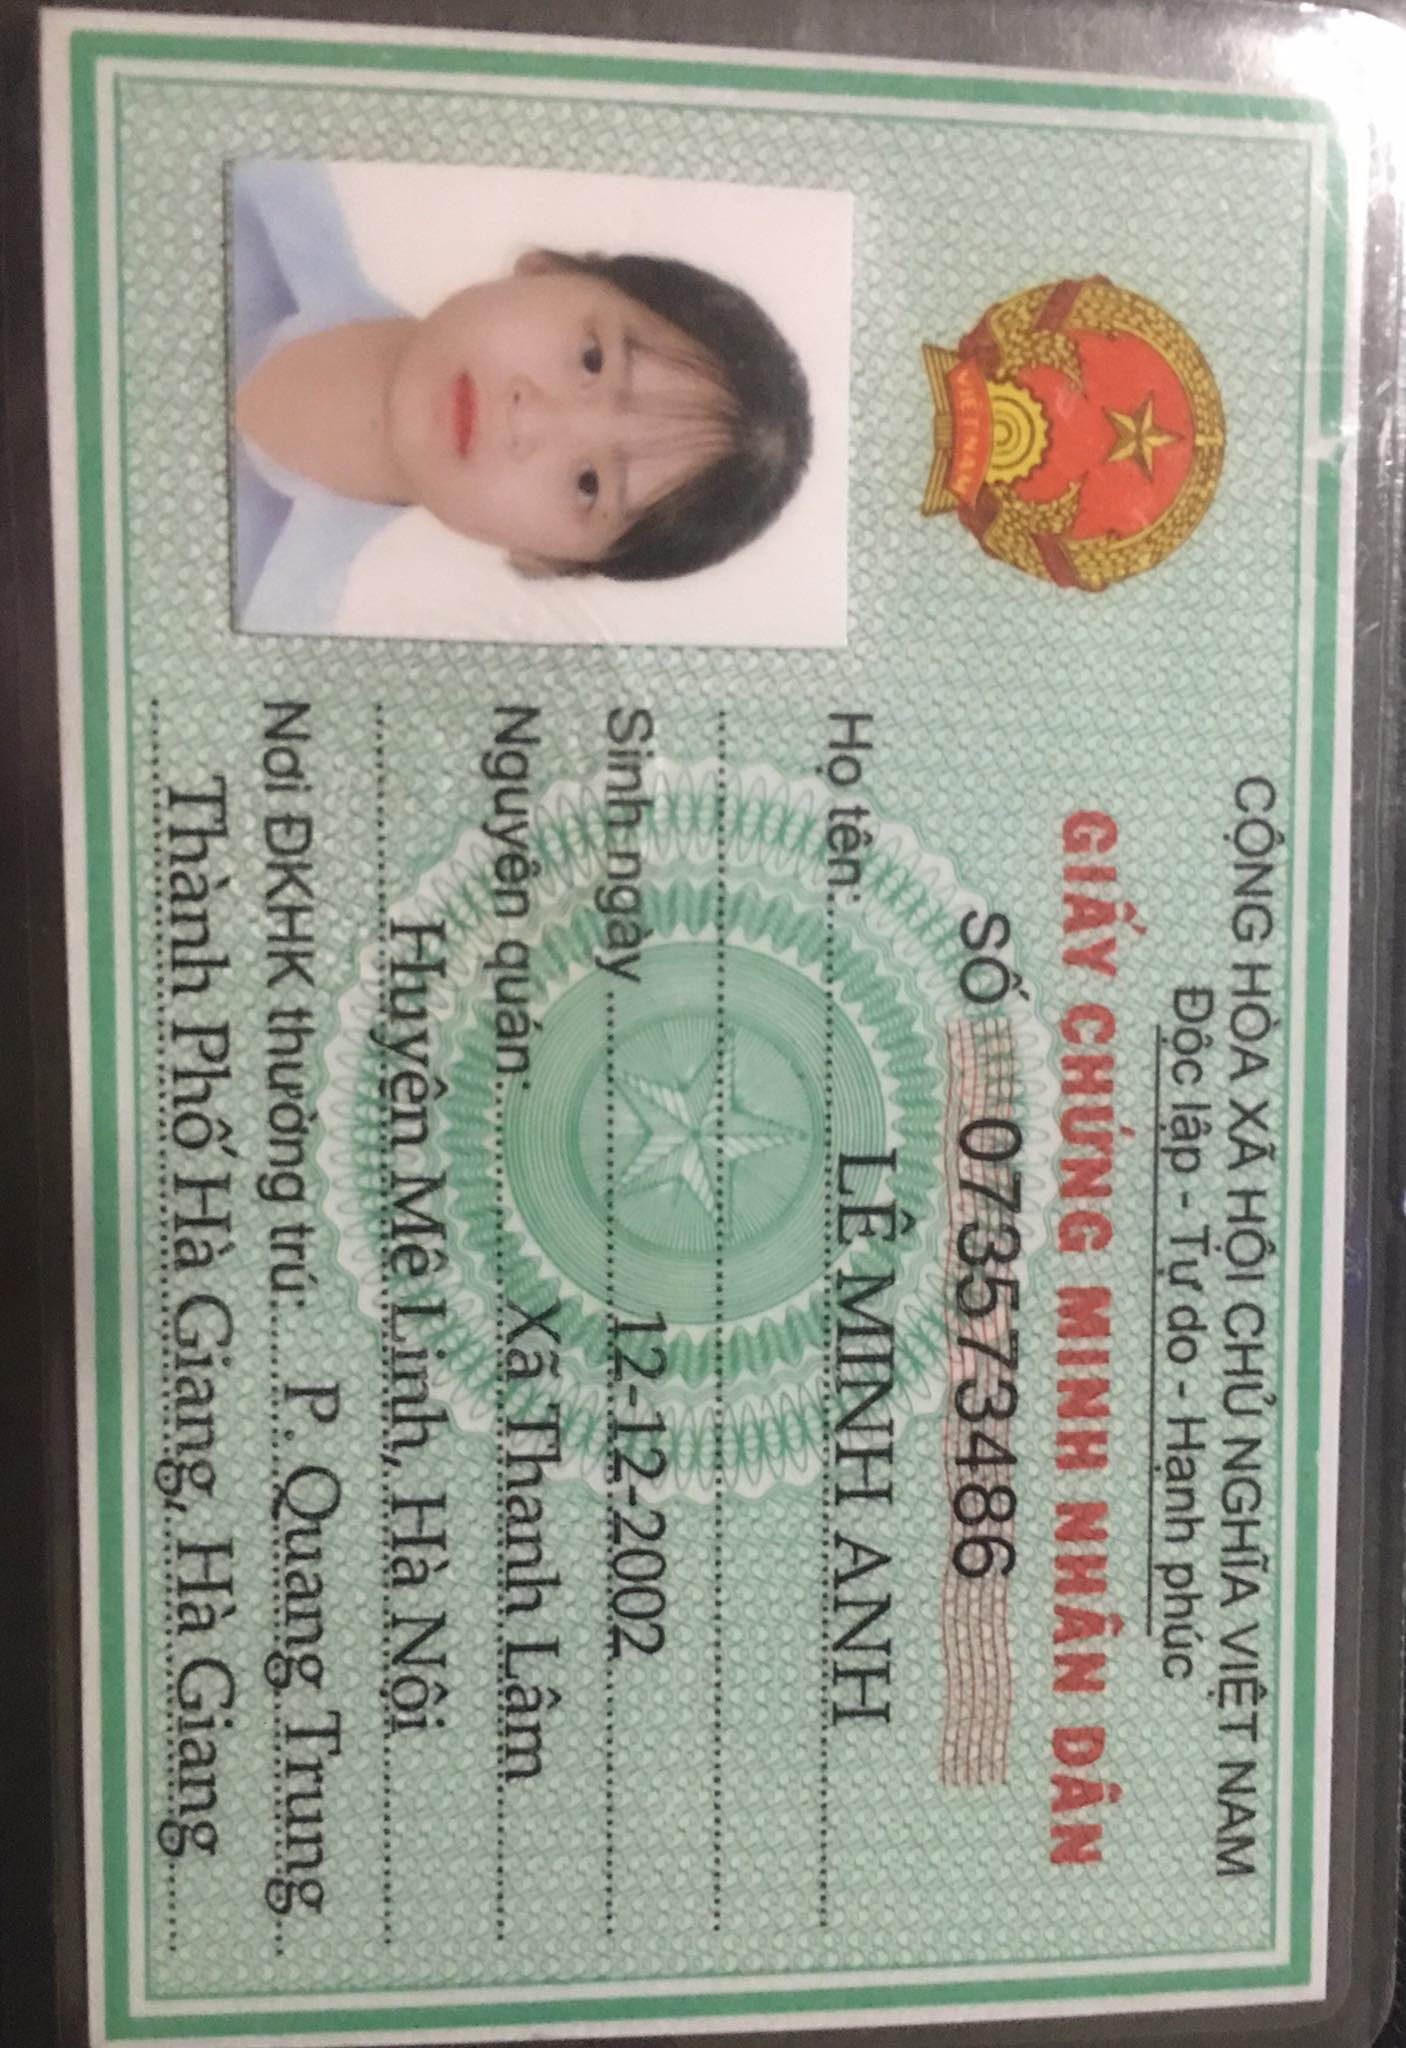

Cropped and rectified image: 


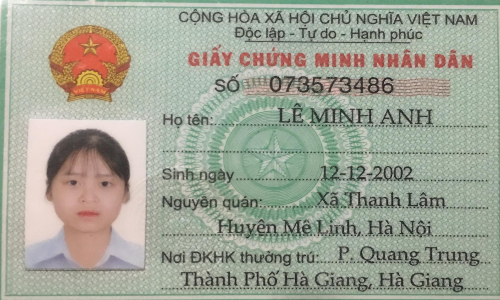

In [24]:
img_path = '/content/front.png'
img = cv2.imread(img_path)
cropped_img = model.detect_corner(img)
cv2.imwrite('result.png', cropped_img)
print('Original image: ')
cv2_imshow(img)
print('Cropped and rectified image: ')
cv2_imshow(cropped_img)

<h3> Detection </h3>

Crop size:  (300, 500, 3)
Boxes:  [array([ 74, 266,  96, 395]), array([102, 275, 125, 306]), array([103, 311, 127, 374]), array([104, 378, 127, 434]), array([161, 317, 181, 414]), array([243, 338, 263, 356]), array([243, 361, 266, 420]), array([243, 421, 267, 479]), array([267, 178, 289, 238]), array([268, 241, 288, 279]), array([268, 282, 289, 308]), array([268, 313, 291, 369]), array([269, 377, 290, 405]), array([270, 407, 293, 465]), array([187, 315, 207, 340]), array([187, 343, 210, 401]), array([188, 403, 209, 447]), array([215, 213, 238, 277]), array([215, 281, 236, 311]), array([216, 316, 237, 357]), array([216, 365, 237, 394]), array([216, 395, 237, 434])]


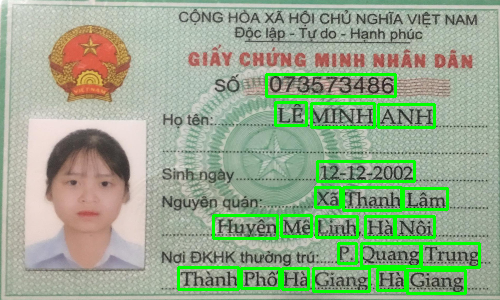

In [25]:
# Detect and save to its attribute
model.detect_text(cropped_img)
print('Crop size: ', np.array(cropped_img).shape)

boxes = list(itertools.chain(model.id_boxes, model.name_boxes, model.birth_boxes, model.add_boxes, model.home_boxes))
print('Boxes: ', boxes)

cropped_img_cp = cropped_img.copy()
for b in boxes:
    top_left, bot_right = (b[1], b[0]), (b[3], b[2])
    cv2.rectangle(cropped_img_cp, top_left, bot_right, color=(0, 255, 0), thickness=2)
cv2_imshow(cropped_img_cp)